### UCCD2063 ARTIFICIAL INTELLIGENCE TECHNIQUES
### TRIMESTER MAY 2018 PRACTICAL ASSIGNMENT

# World Cup 2018


# 1.0 Preparing the training set

In [178]:
import numpy as np
import pandas as pd
from datetime import datetime

#Load raw data fifa_rank['']
fifa_rank = pd.read_csv("Fifa_ranking.csv")
past_match = pd.read_csv("pastMatches.csv")

#Standardize country name
fifa_rank['country'].replace(to_replace='Germany DR', value='Germany', inplace=True)
fifa_rank['country'].replace(to_replace='IR Iran', value='Iran', inplace=True)
fifa_rank['country'].replace(to_replace='China PR', value='China', inplace=True)

#Fix date format to datetime datatype
fifa_rank['rank_date'] = pd.to_datetime(fifa_rank['rank_date'], format='%Y-%m-%d')
past_match['date'] = pd.to_datetime(past_match['date'], format='%d-%m-%Y')


## 1.1 Preprocessing fifa_ranking.csv


In [179]:
#Filter data from 24th August 2011 onwards for fifa_rank
fifa_rank = fifa_rank[fifa_rank.rank_date >= '2011-08-24']

#Compute weighted points of EQ1
fifa_rank['weighted_points'] = fifa_rank['avg_points_curyear'] + (0.5 * fifa_rank['avg_points_1year_ago']) + (0.3 * fifa_rank['avg_points_2years_ago']) + (0.2 * fifa_rank['avg_points_3years_ago'])

#Group by year, country. Then, compute weighted_points and average rank
fifa_rank['year'] = fifa_rank['rank_date'].dt.year
fifa_rank = fifa_rank[['year', 'country', 'weighted_points', 'rank']]
fifa_rank = fifa_rank.groupby(['year', 'country'], as_index=False).mean()


#show top 5 results
fifa_rank.head(5)


,year,country,weighted_points,rank
0,2011,Afghanistan,74.3700,180.6
1,2011,Albania,476.3766,69.6
2,2011,Algeria,689.2576,37.4
3,2011,American Samoa,12.1420,199.8
4,2011,Andorra,0.0000,203.8


## 1.2 Preprocessing matches.csv



In [180]:
#Filter data from 24th August 2011 onwards
past_match = past_match[past_match.date >= '24-08-2011']

#Remove rows which contains "Friendly" in the tournament column
past_match = past_match[past_match.tournament != 'Friendly']

#Remove irrelevant columns
past_match.drop(['city', 'tournament'], axis=1, inplace=True)
past_match['year'] = past_match['date'].dt.year

#show the top 5 rows
past_match.head(5)


,date,team1,team2,team1_score,team2_score,country,year
32808,2011-08-27,Tahiti,Fiji,0,3,New Caledonia,2011
32810,2011-08-27,New Caledonia,Vanuatu,5,0,New Caledonia,2011
32812,2011-08-27,Cook Islands,Papua New Guinea,0,4,New Caledonia,2011
32813,2011-08-27,Guam,Solomon Islands,0,7,New Caledonia,2011
32814,2011-08-27,American Samoa,Tuvalu,0,4,New Caledonia,2011


## 1.3 Merging the ranking and match information


In [181]:
#------------------------------------GETTING THE RANKING FOR TEAM1--------------------------------------
merge1 = past_match.merge(fifa_rank, left_on=['team1', 'year'], right_on=['country', 'year'], how='inner')

#Drop country_y, because its same as team1
merge1.drop('country_y', axis=1, inplace=True)

#Rename country_x to country, rank to team1_rank, weighted_points to team1_weighted_points
merge1 = merge1.rename(columns={'country_x':'country', 'rank':'team1_rank', 'weighted_points':'team1_weighted_points'})


#------------------------------------GETTING THE RANKING FOR TEAM2--------------------------------------
merge2 = merge1.merge(fifa_rank, left_on=['team2', 'year'], right_on=['country', 'year'], how='inner')

#Drop country_y, because its same as team2
merge2.drop('country_y', axis=1, inplace=True)

#Rename country_x to country, rank to team2_rank, weighted_points to team2_weighted_points
merge2 = merge2.rename(columns={'country_x':'country', 'rank':'team2_rank', 'weighted_points':'team2_weighted_points'})

#show top 5 results
merge2.head(5)

,date,team1,team2,team1_score,team2_score,country,year,team1_weighted_points,team1_rank,team2_weighted_points,team2_rank
0,2011-08-27,Tahiti,Fiji,0,3,New Caledonia,2011,68.930,183.0,152.6174,151.2
1,2011-09-09,Tahiti,Fiji,2,1,New Caledonia,2011,68.930,183.0,152.6174,151.2
2,2011-09-03,Cook Islands,Fiji,1,4,New Caledonia,2011,13.742,196.2,152.6174,151.2
3,2011-08-30,Tahiti,Cook Islands,7,0,New Caledonia,2011,68.930,183.0,13.7420,196.2
4,2011-11-26,Tonga,Cook Islands,2,1,Samoa,2011,22.100,194.8,13.7420,196.2


## 1.4 Generating the training set


In [182]:
#Feature Extraction

#------------------------------------------X_train for input matrix--------------------------------------------------------
#country --->country where the match was hosted, based on pastMatches.csv
#merge2['home_match_0'] #team1 is hosting country
#merge2['home_match_1'] #team2 is hosting country
#merge2['home_match_2'] #neither team2 or team2 is hosting country   
merge2['home_match_0'] = np.where(merge2['team1']==merge2['country'], True, False)
merge2['home_match_1'] = np.where(merge2['team2']==merge2['country'], True, False)
merge2['home_match_2'] = np.where((merge2['home_match_0']==False) & (merge2['home_match_1']== False), True, False)
     
merge2['weighted_diff'] = merge2['team1_weighted_points'] - merge2['team2_weighted_points']
merge2['rank_diff'] = merge2['team1_rank'] - merge2['team2_rank']
X_train = merge2[['team1_rank', 'team2_rank', 'team1_weighted_points', 'team2_weighted_points', 'home_match_0','home_match_1', 'home_match_2','weighted_diff', 'rank_diff']]

#show top 5 results
X_train.head(5)


,team1_rank,team2_rank,team1_weighted_points,team2_weighted_points,home_match_0,home_match_1,home_match_2,weighted_diff,rank_diff
0,183.0,151.2,68.930,152.6174,False,False,True,-83.6874,31.8
1,183.0,151.2,68.930,152.6174,False,False,True,-83.6874,31.8
2,196.2,151.2,13.742,152.6174,False,False,True,-138.8754,45.0
3,183.0,196.2,68.930,13.7420,False,False,True,55.1880,-13.2
4,194.8,196.2,22.100,13.7420,False,False,True,8.3580,-1.4


In [183]:
#------------------------------------------y_train for output vector-------------------------------------------

#Labeled output is based on Team1's winning status 
merge2['Winner_Team1'] = np.where(merge2['team1_score'] > merge2['team2_score'], True, False)
y_train = merge2['Winner_Team1']

#show top 5 results
y_train.head(5)

0    False
1     True
2    False
3     True
4     True
Name: Winner_Team1, dtype: bool

# 2.0: Training and evaluating the training set


In [184]:
from sklearn.linear_model import LogisticRegression

#Creates the regressor object
log_reg = LogisticRegression() 

#Trains the model on training set (X_train, y_train)
log_reg.fit(X_train, y_train)

#Evaluate the performance of our model
y_pred = log_reg.predict(X_train)

#Returns the coefficient of determination R^2 of the prediction
print(log_reg.score(X_train, y_train))

0.7485884101040119


In [185]:
#Measuring training accuracy using Cross-Validation
from sklearn.model_selection import cross_validate

#Perform 5-fold cross-validation, and compute accuracy
k_fold_scores = cross_validate(log_reg, X_train, y_train, scoring='accuracy', cv=5, return_train_score=True)
k_fold_scores

{'fit_time': array([0.00996995, 0.00997305, 0.00897765, 0.01099539, 0.0079844 ]),
 'score_time': array([0.0009973 , 0.0009973 , 0.0010004 , 0.        , 0.00099921]),
 'test_score': array([0.75037147, 0.76077266, 0.72956909, 0.75185736, 0.74888559]),
 'train_score': array([0.74925706, 0.74777117, 0.75185736, 0.74628529, 0.75111441])}

In [186]:
#To get average training accuracy & average validation accuracy
print('Average training accuracy = {:.4f}'.format(k_fold_scores['train_score'].mean()))
print('Average validation accuracy = {:.4f}'.format(k_fold_scores['test_score'].mean()))

Average training accuracy = 0.7493
Average validation accuracy = 0.7483


In [187]:
#-------------------------PERFORMANCE MEASURE: ACTUAL VS PREDICTED---------------------------
from sklearn.model_selection import cross_val_predict

#5-fold of cross-validation
y_pred_cv = cross_val_predict (log_reg, X_train, y_train, cv=5)

def peek_results(actual, predicted, num = 15):
    print('Actual |Predicted')
    print('------------------')
    for i in range(num):
        sel = np.random.randint(0, len(y_train))
        print(actual[sel], ' |', predicted[sel])

#Print out the actual value and predicted value for Winner for team1 for 15 matches randomly generated
peek_results(y_train, y_pred_cv)

Actual |Predicted
------------------
True  | False
False  | True
True  | False
True  | False
True  | True
True  | True
False  | False
False  | False
False  | False
True  | True
False  | True
False  | False
True  | True
False  | False
True  | True


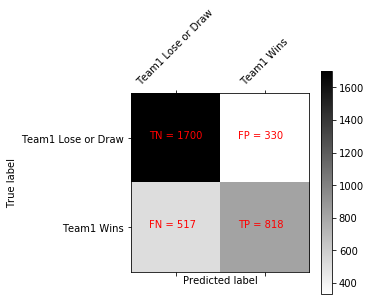

In [188]:
#-------------------------PERFORMANCE MEASURE: CONFUSION MATRIX---------------------------
from sklearn.metrics import confusion_matrix
import matplotlib
import matplotlib.pyplot as plt

#Pass in actual label, and predicted label
confuse_matrix = confusion_matrix (y_train, y_pred_cv)

#Visualize the confusion matrix
def display_confusion_matrix(confuse_matrix):
    plt.matshow(confuse_matrix, cmap = 'binary')
    plt.colorbar()

    # set the x and y label
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # set the tick marks
    classNames = ['Team1 Lose or Draw', 'Team1 Wins']
    tick_marks = np.arange(len(classNames))
    _, _ = plt.xticks(tick_marks, classNames, rotation=45)
    _, _ = plt.yticks(tick_marks, classNames)

    # show count on each quadrant
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            if i == 0 and j == 0:
                plt.text(j-0.3,i, str(s[i][j])+" = "+str(confuse_matrix[i][j]), color='red')
            else:
                plt.text(j-0.3,i, str(s[i][j])+" = "+str(confuse_matrix[i][j]), color='red')       
    
    plt.show() 

display_confusion_matrix(confuse_matrix)

In [189]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("Precision: ", precision_score(y_train, y_pred_cv))
print("Recall Score: ", recall_score(y_train, y_pred_cv))
print("F1 Score: ", f1_score(y_train, y_pred_cv))

Precision:  0.7125435540069687
Recall Score:  0.6127340823970038
F1 Score:  0.6588803866290778


# 3.0 Predicting the output of WorldCup 2018

## 3.1 Generating the input matrix for testing set

#### Developed by Chong Wen Jin, Vivaaindrean Ng

In [190]:
#load in the datasets for Group Stage of World Cup - 32 teams
world_cup = pd.read_csv("WorldCup2018_Groups.csv")

world_cup.head()

,Team,Group
0,Russia,A
1,Saudi Arabia,A
2,Egypt,A
3,Uruguay,A
4,Portugal,B


In [191]:
#Pair up teams in each group to generate 48 matches
import itertools as iter
from itertools import combinations

world_cup = pd.read_csv("WorldCup2018_Groups.csv")
world_cup.head(5)

f = lambda x : pd.DataFrame(list(combinations(x.values,2)), columns=['team1', 'team2'])

world_cup = (world_cup.groupby('Group')['Team'].apply(f).reset_index(level=1, drop=True).reset_index())

year_2018 = fifa_rank[fifa_rank["year"] == 2018].copy()
world_cup = pd.merge(world_cup, year_2018, left_on=["team1"], right_on=["country"])
world_cup = pd.merge(world_cup, year_2018, left_on=["team2"], right_on=["country"])
world_cup.drop(["year_x","year_y", "country_x", "country_y"], axis = 1, inplace = True)
world_cup.rename(columns={"weighted_points_x": "team1_weighted_points", "rank_x": "team1_rank", 
                          "weighted_points_y": "team2_weighted_points", "rank_y": "team2_rank"}, inplace = True)
world_cup.head()

,Group,team1,team2,team1_weighted_points,team1_rank,team2_weighted_points,team2_rank
0,A,Russia,Saudi Arabia,506.775333,64.666667,484.787500,67.000000
1,A,Russia,Egypt,506.775333,64.666667,683.972500,42.333333
2,A,Saudi Arabia,Egypt,484.787500,67.000000,683.972500,42.333333
3,A,Russia,Uruguay,506.775333,64.666667,958.436833,19.000000
4,A,Saudi Arabia,Uruguay,484.787500,67.000000,958.436833,19.000000


In [192]:
test_weighted_diff = (world_cup["team1_weighted_points"] - world_cup["team2_weighted_points"])
test_rank_diff = (world_cup["team1_rank"] - world_cup["team2_rank"])
test_home_match_0 = (world_cup["team1"] == "Russia")
test_home_match_1 = (world_cup["team2"] == "Russia")
test_home_match_2 = (~test_home_match_0 & ~test_home_match_1)
x_test = world_cup[["team1_rank", "team2_rank", "team1_weighted_points", "team2_weighted_points"]]
x_test = x_test.join(pd.DataFrame({"home_match_0" : test_home_match_0, "home_match_1" : test_home_match_1, "home_match_2" : test_home_match_2, "weighted_diff" : test_weighted_diff, "rank_diff" : test_rank_diff}, 
                                  columns=["home_match_0", "home_match_1", "home_match_2", "weighted_diff", "rank_diff"]))
x_test.head()

,team1_rank,team2_rank,team1_weighted_points,team2_weighted_points,home_match_0,home_match_1,home_match_2,weighted_diff,rank_diff
0,64.666667,67.000000,506.775333,484.787500,True,False,False,21.987833,-2.333333
1,64.666667,42.333333,506.775333,683.972500,True,False,False,-177.197167,22.333333
2,67.000000,42.333333,484.787500,683.972500,False,False,True,-199.185000,24.666667
3,64.666667,19.000000,506.775333,958.436833,True,False,False,-451.661500,45.666667
4,67.000000,19.000000,484.787500,958.436833,False,False,True,-473.649333,48.000000


## 3.2 Predicting the WorldCup 2018 matches

#### Developed by Chong Wen Jin, Vivaaindrean Ng

In [195]:
predicted_outcome = log_reg.predict(x_test)
df = pd.DataFrame(world_cup, columns = ["team1", "team2"])
df["team1_wins"] = predicted_outcome
df.to_csv("Result.csv")